# Probabilistic Neural Networks

In [1]:
import numpy as np
import jax.numpy as jnp
np.random.seed(0)
import tqdm
from flax import linen as nn
from jax import jit, random, lax
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.module import random_flax_module, flax_module
from numpyro.infer import (
    Predictive,
    SVI,
    TraceMeanField_ELBO,
    autoguide,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)

from jax import config
config.update("jax_enable_x64", True)

%matplotlib inline

## Data

In [2]:
def generate_data(n_samples: int = 100, latent: bool = False, sigma: float = 0.01):

    if not latent:
        x = 2.5 * np.random.normal(size=n_samples)
        y = np.sin(x) / x + sigma * np.random.normal(size=n_samples)
    else:
        x = 5.5 * np.random.normal(size=n_samples)
        x = np.sort(x)
        y = np.sin(x) / x

    return x, y

In [3]:
n_train_data = 1_000
n_test_data = 1_000
n_plot_data = 5_000

x_train, y_train = generate_data(n_train_data)
x_test, y_test = generate_data(n_test_data)
x_plot, y_plot = generate_data(n_plot_data, latent=True)

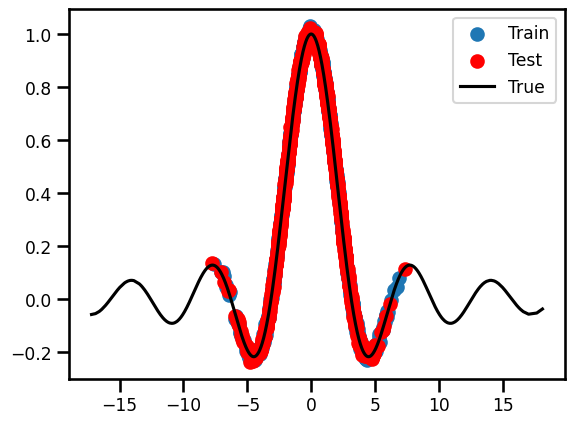

In [4]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color="tab:blue", label="Train")
ax.scatter(x_test, y_test, color="red", label="Test")
ax.plot(x_plot, y_plot, color="black", label="True")

plt.legend()
plt.show()

## Deterministic Neural Networkz

In [5]:
class Net(nn.Module):

    n_units: int

    @nn.compact
    def __call__(self, x):

        x = nn.Dense(self.n_units)(x[...,None])

        x = nn.swish(x)

        x = nn.Dense(self.n_units)(x)

        x = nn.swish(x)

        mean = nn.Dense(1)(x)

        return mean.squeeze()

In [6]:
def nn_model(x, y=None, batch_size=None):

    module = Net(n_units=32)

    # net = random_flax_module("nn", module, dist.Normal(0, 0.1), input_shape=())
    net = flax_module("nn", module, input_shape=())

    with numpyro.plate("batch", x.shape[0], subsample_size=batch_size):

        batch_x = numpyro.subsample(x, event_dim=0)

        batch_y = numpyro.subsample(y, event_dim=0) if y is not None else None

        mean = net(batch_x)

        numpyro.sample("obs", dist.Normal(loc=mean, scale=0.01), obs=batch_y)

In [7]:
guide = autoguide.AutoDelta(nn_model, init_loc_fn=init_to_feasible)

svi = SVI(nn_model, guide, numpyro.optim.Adam(5e-3), TraceMeanField_ELBO())

n_iterations = 10_000

svi_result = svi.run(random.PRNGKey(0), n_iterations, x_train, y_train, batch_size=32)

params, losses = svi_result.params, svi_result.losses

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10866.96it/s, init loss: 12914691.1206, avg. loss [9501-10000]: -2588.2746]


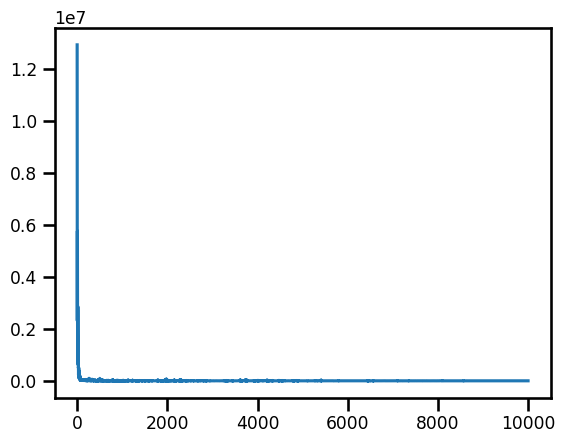

In [8]:
plt.plot(losses)

### Predictions

In [9]:
# initialize predictor
predictive = Predictive(nn_model, guide=guide, params=params, num_samples=1000)

# make predictions
y_pred = predictive(random.PRNGKey(1), x_plot)["obs"].copy()

# calculate quantile
y_upper, y_mu, y_lower = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=0)

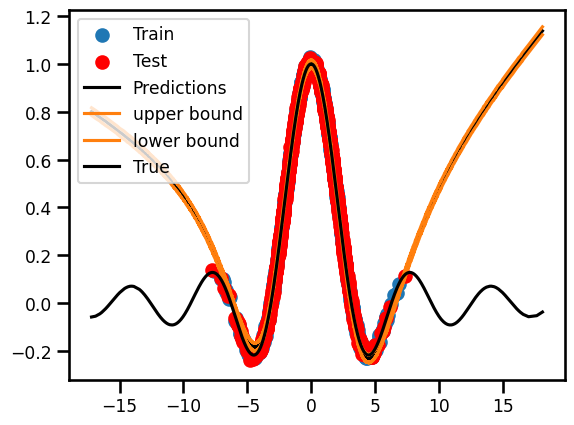

In [10]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color="tab:blue", label="Train")
ax.scatter(x_test, y_test, color="red", label="Test")
plt.plot(x_plot, y_mu, color="black", label="Predictions")
plt.plot(x_plot, y_upper, color="tab:orange", label="upper bound")
plt.plot(x_plot, y_lower, color="tab:orange", label="lower bound")
ax.plot(x_plot, y_plot, color='black', label='True')

plt.legend()
plt.show()

## Probabilistic Neural Network

In [11]:
class Net(nn.Module):

    n_units: int

    @nn.compact
    def __call__(self, x):

        x = nn.Dense(self.n_units)(x[...,None])

        x = nn.gelu(x)

        x = nn.Dense(self.n_units)(x)

        x = nn.gelu(x)

        mean = nn.Dense(1)(x)

        rho = nn.Dense(1)(x)

        return mean.squeeze(), rho.squeeze()

In [12]:
	
def probnn_model(x, y=None, batch_size=None):

    module = Net(n_units=32)

    net = flax_module("nn", module, input_shape=())

    with numpyro.plate("batch", x.shape[0], subsample_size=batch_size):

        batch_x = numpyro.subsample(x, event_dim=0)

        batch_y = numpyro.subsample(y, event_dim=0) if y is not None else None

        mean, rho = net(batch_x)

        sigma = nn.softplus(rho + 1e-10)

        numpyro.sample("obs", dist.Normal(mean, sigma), obs=batch_y)

### Inference

In [13]:
guide = autoguide.AutoNormal(probnn_model, init_loc_fn=init_to_feasible)

svi = SVI(probnn_model, guide, numpyro.optim.Adam(5e-3), TraceMeanField_ELBO())

n_iterations = 50_000

svi_result = svi.run(random.PRNGKey(0), n_iterations, x_train, y_train, batch_size=32)

params, losses = svi_result.params, svi_result.losses

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:03<00:00, 13010.18it/s, init loss: 22783752541.7940, avg. loss [47501-50000]: -3031.5974]


In [14]:
# initialize predictor
predictive = Predictive(probnn_model, guide=guide, params=params, num_samples=1000)

# make predictions
y_pred = predictive(random.PRNGKey(1), x_plot)["obs"].copy()

# calculate quantile
y_upper, y_mu, y_lower = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=0)

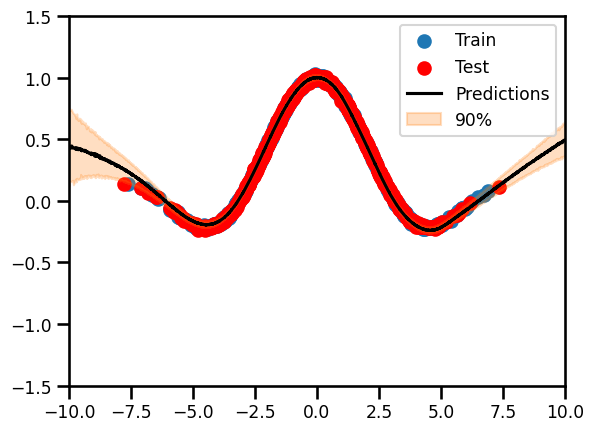

In [15]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color="tab:blue", label="Train")
ax.scatter(x_test, y_test, color="red", label="Test")
plt.plot(x_plot, y_mu, color="black", label="Predictions")
plt.fill_between(x_plot, y_upper, y_lower, color="tab:orange", alpha=0.25, label="90%")
# plt.plot(x_plot, y_lower, color="tab:orange", label="lower bound")
# ax.plot(x_plot, y_plot, color='black', label='True')

ax.set(xlim=[-10,10], ylim=[-1.5, 1.5])
plt.legend()
plt.show()

## Bayesian Neural Network

In [20]:
def bnn_model(x, y=None, batch_size=None):

    module = Net(n_units=16)

    net = random_flax_module("nn", module, dist.Normal(0, 0.1), input_shape=())
    # net = flax_module("nn", module, input_shape=())

    with numpyro.plate("batch", x.shape[0], subsample_size=batch_size):

        batch_x = numpyro.subsample(x, event_dim=0)

        batch_y = numpyro.subsample(y, event_dim=0) if y is not None else None

        mean, rho = net(batch_x)

        sigma = nn.softplus(rho + 1e-10)

        numpyro.sample("obs", dist.Normal(mean, sigma), obs=batch_y)

### Inference

In [21]:
guide = autoguide.AutoNormal(bnn_model, init_loc_fn=init_to_feasible())

svi = SVI(bnn_model, guide, numpyro.optim.Adam(5e-3), TraceMeanField_ELBO())

n_iterations = 30_000

svi_result = svi.run(random.PRNGKey(0), n_iterations, x_train, y_train, batch_size=16)

params, losses = svi_result.params, svi_result.losses

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5539.34it/s, init loss: 1033.7652, avg. loss [28501-30000]: -1684.8758]


In [22]:
# initialize predictor
predictive = Predictive(bnn_model, guide=guide, params=params, num_samples=1000)

# make predictions
y_pred = predictive(random.PRNGKey(1), x_plot)["obs"].copy()

# calculate quantile
y_upper, y_mu, y_lower = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=0)

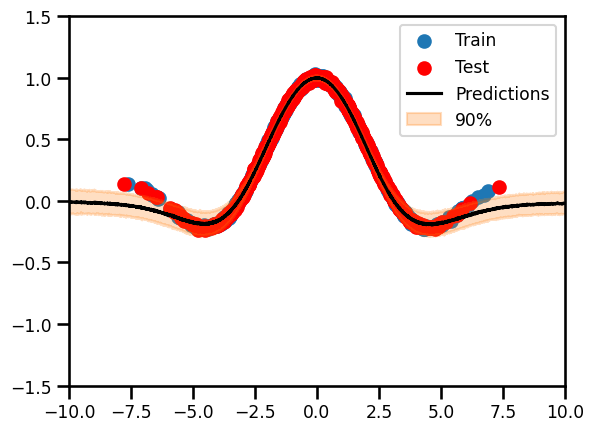

In [23]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color="tab:blue", label="Train")
ax.scatter(x_test, y_test, color="red", label="Test")
plt.plot(x_plot, y_mu, color="black", label="Predictions")
plt.fill_between(x_plot, y_upper, y_lower, color="tab:orange", alpha=0.25, label="90%")
# plt.plot(x_plot, y_lower, color="tab:orange", label="lower bound")
# ax.plot(x_plot, y_plot, color='black', label='True')

ax.set(xlim=[-10,10], ylim=[-1.5, 1.5])
plt.legend()
plt.show()